In [33]:
import numpy as np
import types
import random
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras import losses, optimizers
from keras.utils import to_categorical

In [34]:
class Individual:
    
    def __init__(self, weight_dim, model, x_training, y_training, lower_bound, upper_bound):
        self.model = model
        self.weight_dim = weight_dim
        self.x_training = x_training
        self.y_training = y_training
        self.lower = lower_bound
        self.upper = upper_bound
        self.weightNN = self.calculateWeightNN() # oblik koji je potreban za model NN
        self.weightGA = self.NNtoGAshape() # 1 dimenzioni niz
        self.fitness = self.calculateFitness()
        
    
    def __gt__(self, other):
        return self.fitness < other.fitness
    
    def calculateFitness(self):
        self.model.set_weights(self.weightNN)
        train_loss, train_accuracy = self.model.evaluate(self.x_training, self.y_training, verbose = 0)
        
        return train_accuracy

    def calculateWeightNN(self):
        weight = []
        
        for dim in self.weight_dim:
            if(len(dim) == 1):
                bias = np.random.uniform(low = self.lower, high = self.upper, size=(dim[0]))
                weight.append(bias)
            else:
                matrix = np.random.uniform(low = self.lower, high = self.upper, size=(dim[0], dim[1]))
                weight.append(matrix)
        
        return weight
    
    # weightNN -> weightGA
    def NNtoGAshape(self):
        weightGA = []
        
        for w in self.weightNN:
            for arr in w:
                if isinstance(arr, np.ndarray):
                    row = np.ndarray.tolist(arr)
                    for one in row:
                        weightGA.append(one)
                else:
                    weightGA.append(arr)
        return weightGA
        
    # weightGA -> weightGA
    def GAtoNNshape(self):
        weightNN = []
        
        i = 0
        for dim in self.weight_dim:
            array = []
            if(len(dim) == 1):
                n = dim[0]
                array.append(self.weightGA[i:i+n])
                i += n
                weightNN.append(np.asarray(array[0]))
            else:
                for k in range(dim[0]):
                    row = []
                    for j in range(dim[1]):
                        row.append(self.weightGA[i])
                        i += 1
                    array.append(row)
                weightNN.append(np.asarray(array))
        return weightNN

In [35]:
def selection(population):
    fitness_sum = sum(i.fitness for i in population)
    value = random.uniform(0, fitness_sum)
    current = 0
    for i in range(0,len(population)):
        current += population[i].fitness
        if current > value:
            return i
    

def crossover(parent1, parent2, child1, child2):
    n = len(parent1.weightGA)
    
    breakpoint1 = random.randrange(0, int(n/2))
    breakpoint2 = random.randrange(int(n/2)+1, n)
    
    child1.weightGA[:breakpoint1] = parent1.weightGA[:breakpoint1]
    child2.weightGA[:breakpoint1] = parent2.weightGA[:breakpoint1]
    
    child1.weightGA[breakpoint1:breakpoint2] = parent2.weightGA[breakpoint1:breakpoint2]
    child2.weightGA[breakpoint1:breakpoint2] = parent1.weightGA[breakpoint1:breakpoint2]
    
    child1.weightGA[breakpoint2:] = parent1.weightGA[breakpoint2:]
    child2.weightGA[breakpoint2:] = parent2.weightGA[breakpoint2:]
    
    child1.weightNN = child1.GAtoNNshape()
    child2.weightNN = child2.GAtoNNshape()

def mutation(individual, prob):
    for i in range(len(individual.weightGA)):
        if random.random() < prob:
            individual.weightGA[i] = random.uniform(individual.lower, individual.upper)
    
    individual.weightNN = individual.GAtoNNshape()

In [36]:
def NNwithGAoptimisation(population_size, max_iter, data):

    x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    
    model = Sequential()
    model.add(Dense(units=100, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(units=y_train.shape[1], activation='sigmoid'))
    model.summary()
    
    model.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=['accuracy'])
    
    weight_dim = [i.shape for i in model.get_weights()]
    population = [Individual(weight_dim, model, x_train, y_train, -1, 1) for i in range(population_size)]
    newPopulation = [Individual(weight_dim, model, x_train, y_train, -1, 1) for i in range(population_size)]

    elitism = int(0.2 * population_size)
    best_fitness = 0
    best_weight = []
    for i in range(max_iter):
    
        population.sort()
        newPopulation[:elitism] = population[:elitism]
    
        for j in range(elitism, population_size-1, 2):
        
            parent1 = selection(population)
            parent2 = selection(population)
        
            crossover(population[parent1], population[parent2], newPopulation[j], newPopulation[j+1])

            if(j > population_size-10):
                mutation(newPopulation[j], 0.1)
                mutation(newPopulation[j+1], 0.1)
            else:
                mutation(newPopulation[j], 0.05)
                mutation(newPopulation[j+1], 0.05)
        
            newPopulation[j].fitness = newPopulation[j].calculateFitness()
            newPopulation[j+1].fitness = newPopulation[j+1].calculateFitness()
        
        population = newPopulation
    
        best_individual = max(population, key=lambda x: x.fitness)
        if best_individual.fitness > best_fitness:
            best_fitness = best_individual.fitness
            best_weight = best_individual.weightNN
        
        
    model.set_weights(best_weight)
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose = 0)
    return best_fitness, test_accuracy

In [37]:
def NNwithAdam(data):
    
    x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    model = Sequential()
    model.add(Dense(units=100, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(units=y_train.shape[1], activation='sigmoid'))
    model.summary()

    model.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size = 64, epochs = 150, verbose = 0, validation_split = 0.3)
    
    
    train_loss, train_accuracy = model.evaluate(x_train, y_train)
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    
    return train_accuracy, test_accuracy

In [44]:
iris = datasets.load_iris()

train_iris, test_iris = NNwithGAoptimisation(30, 150, iris)
print('Iris data: Train accuracy = ' + str(train_iris) + ', Test accuracy = ' + str(test_iris))

train_iris_adam, test_iris_adam = NNwithAdam(iris)
print('Iris data: Train accuracy = ' + str(train_iris_adam) + ', Test accuracy = ' + str(test_iris_adam))

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_56 (Dense)             (None, 3)                 303       
Total params: 803
Trainable params: 803
Non-trainable params: 0
_________________________________________________________________
Iris data: Train accuracy = 0.9700000286102295, Test accuracy = 0.9599999785423279
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_58 (Dense)             (None, 3)                 303       
Total params: 803
Trainable params: 803
Non-trainable params: 0
_________________

In [39]:
cancer = datasets.load_breast_cancer()

train_cancer, test_cancer = NNwithGAoptimisation(30, 150, cancer)
print('Cancer data: Train accuracy = ' + str(train_cancer) + ', Test accuracy = ' + str(test_cancer))

train_cancer_adam, test_cancer_adam = NNwithAdam(cancer)
print('Cancer data: Train accuracy = ' + str(train_cancer_adam) + ', Test accuracy = ' + str(test_cancer_adam))

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 202       
Total params: 3,302
Trainable params: 3,302
Non-trainable params: 0
_________________________________________________________________
Cancer data: Train accuracy = 0.9816272854804993, Test accuracy = 0.9521276354789734
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_46 (Dense)             (None, 2)                 202       
Total params: 3,302
Trainable params: 3,302
Non-trainable params: 0
_______

In [40]:
wine = datasets.load_wine()

train_wine, test_wine = NNwithGAoptimisation(30, 150, wine)
print('Wine data: Train accuracy = ' + str(train_wine) + ', Test accuracy = ' + str(test_wine))

train_wine_adam, test_wine_adam = NNwithAdam(wine)
print('Wine data: Train accuracy = ' + str(train_wine_adam) + ', Test accuracy = ' + str(test_wine_adam))

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 100)               1400      
_________________________________________________________________
dense_48 (Dense)             (None, 3)                 303       
Total params: 1,703
Trainable params: 1,703
Non-trainable params: 0
_________________________________________________________________
Wine data: Train accuracy = 0.9747899174690247, Test accuracy = 0.9152542352676392
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 100)               1400      
_________________________________________________________________
dense_50 (Dense)             (None, 3)                 303       
Total params: 1,703
Trainable params: 1,703
Non-trainable params: 0
_________

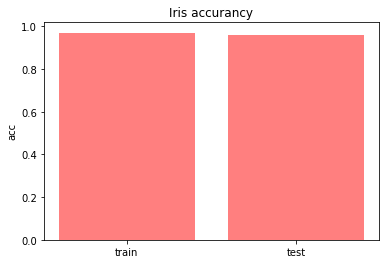

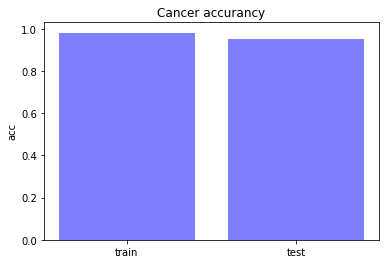

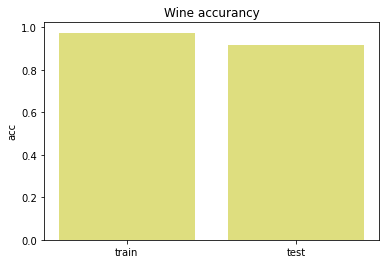

In [45]:
y_pos = np.arange(2)
plt.bar(y_pos, [train_iris, test_iris], align='center', alpha=0.5, color = 'r')
plt.xticks(y_pos, ('train', 'test'))
plt.ylabel('acc')
plt.title('Iris accurancy')

plt.show()

y_pos = np.arange(2)
plt.bar(y_pos, [train_cancer, test_cancer], align='center', alpha=0.5, color = 'b')
plt.xticks(y_pos, ('train', 'test'))
plt.ylabel('acc')
plt.title('Cancer accurancy')

plt.show()

y_pos = np.arange(2)
plt.bar(y_pos, [train_wine, test_wine], align='center', alpha=0.5, color = 'y')
plt.xticks(y_pos, ('train', 'test'))
plt.ylabel('acc')
plt.title('Wine accurancy')

plt.show()

No handles with labels found to put in legend.


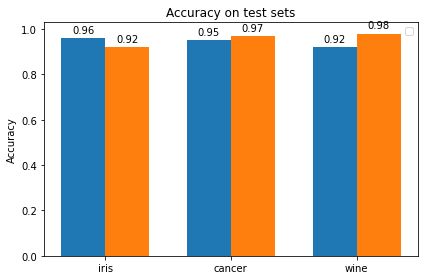

In [46]:
test_GA = [round(test_iris,2), round(test_cancer,2), round(test_wine,2)]
test_adam = [round(test_iris_adam,2), round(test_cancer_adam,2), round(test_wine_adam,2)]

labels = ['iris', 'cancer', 'wine']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, test_GA, width)
rects2 = ax.bar(x + width/2, test_adam, width)

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy on test sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
